# 3-1,低阶API示范

下面的范例使用TensorFlow的低阶API实现线性回归模型和DNN二分类模型。

低阶API主要包括张量操作，计算图和自动微分。

In [2]:
import tensorflow as tf

#打印时间分割线
@tf.function
def printbar():
    today_ts = tf.timestamp()%(24*60*60)

    hour = tf.cast(today_ts//3600+8,tf.int32)%tf.constant(24)
    minite = tf.cast((today_ts%3600)//60,tf.int32)
    second = tf.cast(tf.floor(today_ts%60),tf.int32)
    
    def timeformat(m):
        if tf.strings.length(tf.strings.format("{}",m))==1:
            return(tf.strings.format("0{}",m))
        else:
            return(tf.strings.format("{}",m))
    
    timestring = tf.strings.join([timeformat(hour),timeformat(minite),
                timeformat(second)],separator = ":")
    tf.print("=========="*8+timestring)


### 一，线性回归模型

**1，准备数据**

In [3]:
import numpy as np 
import pandas as pd
from matplotlib import pyplot as plt 
import tensorflow as tf


#样本数量
n = 400

# 生成测试用数据集
X = tf.random.uniform([n,2],minval=-10,maxval=10) 
w0 = tf.constant([[2.0],[-3.0]])
b0 = tf.constant([[3.0]])
Y = X@w0 + b0 + tf.random.normal([n,1],mean = 0.0,stddev= 2.0)  # @表示矩阵乘法,增加正态扰动


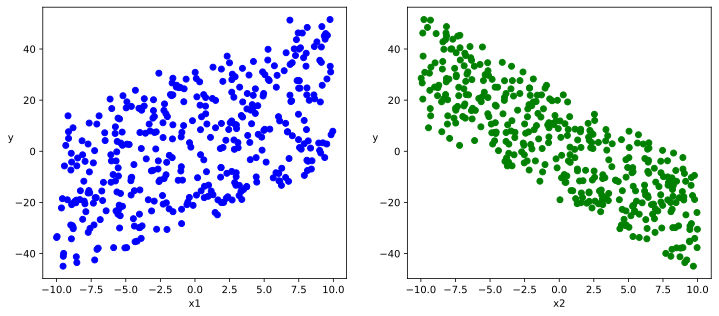

In [4]:
# 数据可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b")
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)

ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g")
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)
plt.show()


![](./data/3-1-01-回归数据可视化.png)

In [5]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = indices[i: min(i + batch_size, num_examples)]
        yield tf.gather(features,indexs), tf.gather(labels,indexs)
        
# 测试数据管道效果   
batch_size = 8
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)


tf.Tensor(
[[-4.304464   -9.353242  ]
 [-3.886547    9.793844  ]
 [ 9.521963    6.081827  ]
 [-8.030257   -1.3978767 ]
 [ 6.5522957   2.0882778 ]
 [ 1.908453   -8.447824  ]
 [ 0.68861485  5.3482294 ]
 [ 2.7008991  -6.666801  ]], shape=(8, 2), dtype=float32)
tf.Tensor(
[[ 23.84537  ]
 [-34.07941  ]
 [  2.8440595]
 [-11.70831  ]
 [ 10.923079 ]
 [ 32.14832  ]
 [-13.6853695]
 [ 30.160309 ]], shape=(8, 1), dtype=float32)


```
tf.Tensor(
[[ 2.6161194   0.11071014]
 [ 9.79207    -0.70180416]
 [ 9.792343    6.9149055 ]
 [-2.4186516  -9.375019  ]
 [ 9.83749    -3.4637213 ]
 [ 7.3953056   4.374569  ]
 [-0.14686584 -0.28063297]
 [ 0.49001217 -9.739792  ]], shape=(8, 2), dtype=float32)
tf.Tensor(
[[ 9.334667 ]
 [22.058844 ]
 [ 3.0695205]
 [26.736238 ]
 [35.292133 ]
 [ 4.2943544]
 [ 1.6713585]
 [34.826904 ]], shape=(8, 1), dtype=float32)
```

**2，定义模型**

In [6]:
w = tf.Variable(tf.random.normal(w0.shape))
b = tf.Variable(tf.zeros_like(b0,dtype = tf.float32))

# 定义模型
class LinearRegression:     
    #正向传播
    def __call__(self,x): 
        return x@w + b

    # 损失函数
    def loss_func(self,y_true,y_pred):  
        return tf.reduce_mean((y_true - y_pred)**2/2)

model = LinearRegression()

**3，训练模型**

In [7]:
# 使用动态图调试
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)
    # 反向传播求梯度
    dloss_dw,dloss_db = tape.gradient(loss,[w,b])
    # 梯度下降法更新参数
    w.assign(w - 0.001*dloss_dw)
    b.assign(b - 0.001*dloss_db)
    
    return loss
 

In [8]:
# 测试train_step效果
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
train_step(model,features,labels)


<tf.Tensor: shape=(), dtype=float32, numpy=179.5505>

```
<tf.Tensor: shape=(), dtype=float32, numpy=211.09982>
```

In [9]:
def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        for features, labels in data_iter(X,Y,10):
            loss = train_step(model,features,labels)

        if epoch%50==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss)
            tf.print("w =",w)
            tf.print("b =",b)

train_model(model,epochs = 200)


================================================================================10:31:19
epoch = 50 loss =  1.49332964
w = [[2.00736833]
 [-2.97882748]]
b = [[2.63043761]]
================================================================================10:31:23
epoch = 100 loss =  2.12115049
w = [[2.00535417]
 [-2.9756639]]
b = [[2.98775]]
================================================================================10:31:27
epoch = 150 loss =  1.83742595
w = [[2.00099301]
 [-2.98321319]]
b = [[3.03565478]]
================================================================================10:31:31
epoch = 200 loss =  1.43313503
w = [[2.00357103]
 [-2.98056579]]
b = [[3.04297781]]


```
================================================================================16:35:56
epoch = 50 loss =  1.78806472
w = [[1.97554708]
 [-2.97719598]]
b = [[2.60692883]]
================================================================================16:36:00
epoch = 100 loss =  2.64588404
w = [[1.97319281]
 [-2.97810626]]
b = [[2.95525956]]
================================================================================16:36:04
epoch = 150 loss =  1.42576694
w = [[1.96466208]
 [-2.98337793]]
b = [[3.00264144]]
================================================================================16:36:08
epoch = 200 loss =  1.68992615
w = [[1.97718477]
 [-2.983814]]
b = [[3.01013041]]
```

In [11]:
##使用autograph机制转换成静态图加速

@tf.function
def train_step(model, features, labels):
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions)
    # 反向传播求梯度
    dloss_dw,dloss_db = tape.gradient(loss,[w,b])
    # 梯度下降法更新参数
    w.assign(w - 0.001*dloss_dw)
    b.assign(b - 0.001*dloss_db)
    
    return loss

def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        for features, labels in data_iter(X,Y,10):
            loss = train_step(model,features,labels)
        if epoch%50==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss)
            tf.print("w =",w)
            tf.print("b =",b)

train_model(model,epochs = 200)


================================================================================10:32:15
epoch = 50 loss =  2.26751
w = [[2.00146365]
 [-2.97657394]]
b = [[3.04363585]]
================================================================================10:32:17
epoch = 100 loss =  3.25219607
w = [[1.99586892]
 [-2.97665477]]
b = [[3.0437789]]
================================================================================10:32:18
epoch = 150 loss =  2.31444144
w = [[2.00026751]
 [-2.9766109]]
b = [[3.04420924]]
================================================================================10:32:19
epoch = 200 loss =  3.06520033
w = [[2.00101423]
 [-2.97664952]]
b = [[3.04353499]]


```
================================================================================16:36:35
epoch = 50 loss =  0.894210339
w = [[1.96927285]
 [-2.98914337]]
b = [[3.00987792]]
================================================================================16:36:36
epoch = 100 loss =  1.58621466
w = [[1.97566223]
 [-2.98550248]]
b = [[3.00998402]]
================================================================================16:36:37
epoch = 150 loss =  2.2695992
w = [[1.96664226]
 [-2.99248481]]
b = [[3.01028705]]
================================================================================16:36:38
epoch = 200 loss =  1.90848124
w = [[1.98000824]
 [-2.98888135]]
b = [[3.01085401]]
```

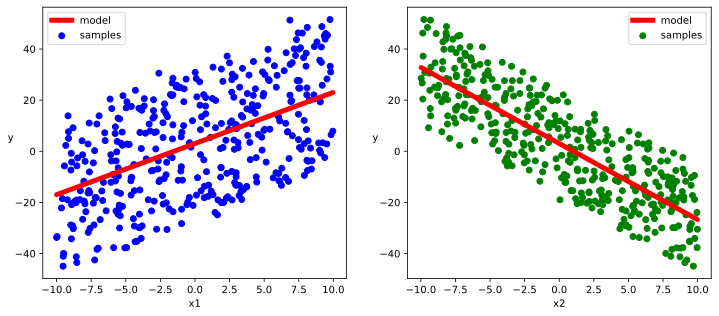

In [12]:
# 结果可视化

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

plt.figure(figsize = (12,5))
ax1 = plt.subplot(121)
ax1.scatter(X[:,0],Y[:,0], c = "b",label = "samples")
ax1.plot(X[:,0],w[0]*X[:,0]+b[0],"-r",linewidth = 5.0,label = "model")
ax1.legend()
plt.xlabel("x1")
plt.ylabel("y",rotation = 0)


ax2 = plt.subplot(122)
ax2.scatter(X[:,1],Y[:,0], c = "g",label = "samples")
ax2.plot(X[:,1],w[1]*X[:,1]+b[0],"-r",linewidth = 5.0,label = "model")
ax2.legend()
plt.xlabel("x2")
plt.ylabel("y",rotation = 0)

plt.show()

![](./data/3-1-2-回归结果可视化.png)

### 二，DNN二分类模型

**1，准备数据**

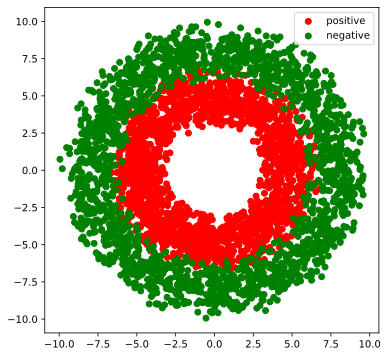

In [13]:
import numpy as np 
import pandas as pd 
from matplotlib import pyplot as plt
import tensorflow as tf
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

#正负样本数量
n_positive,n_negative = 2000,2000

#生成正样本, 小圆环分布
r_p = 5.0 + tf.random.truncated_normal([n_positive,1],0.0,1.0)
theta_p = tf.random.uniform([n_positive,1],0.0,2*np.pi) 
Xp = tf.concat([r_p*tf.cos(theta_p),r_p*tf.sin(theta_p)],axis = 1)
Yp = tf.ones_like(r_p)

#生成负样本, 大圆环分布
r_n = 8.0 + tf.random.truncated_normal([n_negative,1],0.0,1.0)
theta_n = tf.random.uniform([n_negative,1],0.0,2*np.pi) 
Xn = tf.concat([r_n*tf.cos(theta_n),r_n*tf.sin(theta_n)],axis = 1)
Yn = tf.zeros_like(r_n)

#汇总样本
X = tf.concat([Xp,Xn],axis = 0)
Y = tf.concat([Yp,Yn],axis = 0)


#可视化
plt.figure(figsize = (6,6))
plt.scatter(Xp[:,0].numpy(),Xp[:,1].numpy(),c = "r")
plt.scatter(Xn[:,0].numpy(),Xn[:,1].numpy(),c = "g")
plt.legend(["positive","negative"]);


![](./data/3-1-03-分类数据可视化.png)

In [14]:
# 构建数据管道迭代器
def data_iter(features, labels, batch_size=8):
    num_examples = len(features)
    indices = list(range(num_examples))
    np.random.shuffle(indices)  #样本的读取顺序是随机的
    for i in range(0, num_examples, batch_size):
        indexs = indices[i: min(i + batch_size, num_examples)]
        yield tf.gather(features,indexs), tf.gather(labels,indexs)
        
# 测试数据管道效果   
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))
print(features)
print(labels)

tf.Tensor(
[[-5.277445   2.9400854]
 [ 7.1942544  4.377439 ]
 [ 5.0537763  7.3917184]
 [ 3.233339  -7.267056 ]
 [-6.1226864 -5.471059 ]
 [ 5.527899  -2.484958 ]
 [ 2.0689106 -6.595932 ]
 [-5.3362193 -0.5491345]
 [ 4.573667   2.2227557]
 [ 5.488958   0.6798911]], shape=(10, 2), dtype=float32)
tf.Tensor(
[[1.]
 [0.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]], shape=(10, 1), dtype=float32)


```
tf.Tensor(
[[ 0.03732629  3.5783494 ]
 [ 0.542919    5.035079  ]
 [ 5.860281   -2.4476354 ]
 [ 0.63657564  3.194231  ]
 [-3.5072308   2.5578873 ]
 [-2.4109735  -3.6621518 ]
 [ 4.0975413  -2.4172943 ]
 [ 1.9393908  -6.782317  ]
 [-4.7453732  -0.5176727 ]
 [-1.4057113  -7.9775257 ]], shape=(10, 2), dtype=float32)
tf.Tensor(
[[1.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [1.]
 [0.]
 [1.]
 [0.]], shape=(10, 1), dtype=float32)
```

**2，定义模型**

此处范例我们利用tf.Module来组织模型变量，关于tf.Module的较详细介绍参考本书第四章最后一节: Autograph和tf.Module。

In [16]:
class DNNModel(tf.Module):
    def __init__(self,name = None):
        super(DNNModel, self).__init__(name=name)
        self.w1 = tf.Variable(tf.random.truncated_normal([2,4]),dtype = tf.float32)
        self.b1 = tf.Variable(tf.zeros([1,4]),dtype = tf.float32)
        self.w2 = tf.Variable(tf.random.truncated_normal([4,8]),dtype = tf.float32)
        self.b2 = tf.Variable(tf.zeros([1,8]),dtype = tf.float32)
        self.w3 = tf.Variable(tf.random.truncated_normal([8,1]),dtype = tf.float32)
        self.b3 = tf.Variable(tf.zeros([1,1]),dtype = tf.float32)

     
    # 正向传播
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,2], dtype = tf.float32)])  
    def __call__(self,x):
        x = tf.nn.relu(x@self.w1 + self.b1)
        x = tf.nn.relu(x@self.w2 + self.b2)
        y = tf.nn.sigmoid(x@self.w3 + self.b3)
        return y
    
    # 损失函数(二元交叉熵)
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,1], dtype = tf.float32),
                              tf.TensorSpec(shape = [None,1], dtype = tf.float32)])  
    def loss_func(self,y_true,y_pred):  
        #将预测值限制在 1e-7 以上, 1 - 1e-7 以下，避免log(0)错误
        eps = 1e-7
        y_pred = tf.clip_by_value(y_pred,eps,1.0-eps)
        bce = - y_true*tf.math.log(y_pred) - (1-y_true)*tf.math.log(1-y_pred)
        return  tf.reduce_mean(bce)
    
    # 评估指标(准确率)
    @tf.function(input_signature=[tf.TensorSpec(shape = [None,1], dtype = tf.float32),
                              tf.TensorSpec(shape = [None,1], dtype = tf.float32)]) 
    def metric_func(self,y_true,y_pred):
        y_pred = tf.where(y_pred>0.5,tf.ones_like(y_pred,dtype = tf.float32),
                          tf.zeros_like(y_pred,dtype = tf.float32)) # 注意这里tf.where的用法
        acc = tf.reduce_mean(1-tf.abs(y_true-y_pred))
        return acc
    
model = DNNModel()


In [17]:
# 测试模型结构
batch_size = 10
(features,labels) = next(data_iter(X,Y,batch_size))

predictions = model(features)

loss = model.loss_func(labels,predictions)
metric = model.metric_func(labels,predictions)

tf.print("init loss:",loss)
tf.print("init metric",metric)

init loss: 1.63651729
init metric 0.6


```
init loss: 1.76568353
init metric 0.6
```

In [ ]:
print(len(model.trainable_variables))

```
6
```

In [18]:
model.trainable_variables

(<tf.Variable 'Variable:0' shape=(1, 4) dtype=float32, numpy=array([[0., 0., 0., 0.]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1, 8) dtype=float32, numpy=array([[0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(1, 1) dtype=float32, numpy=array([[0.]], dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(2, 4) dtype=float32, numpy=
 array([[ 1.2708834 , -0.8382538 , -1.7461092 , -1.1728789 ],
        [ 1.9001687 , -0.44374496,  0.0952088 , -0.7892935 ]],
       dtype=float32)>,
 <tf.Variable 'Variable:0' shape=(4, 8) dtype=float32, numpy=
 array([[-1.0891467 , -0.3650819 ,  0.241906  ,  0.4191774 ,  0.73840004,
          1.7481389 ,  0.3440832 ,  0.22798818],
        [ 0.48027784, -0.8803723 , -0.5742006 ,  0.4165718 ,  0.647935  ,
         -0.6242886 , -0.35315168, -0.4434685 ],
        [ 0.590023  , -1.2146825 ,  1.1900427 ,  1.2900171 , -0.74301976,
          0.7885005 , -0.2605725 ,  1.2400495 ],
        [-0.36318883,  0.53606516,  0.3557

**3，训练模型**

In [ ]:
##使用autograph机制转换成静态图加速

@tf.function
def train_step(model, features, labels):
    
    # 正向传播求损失
    with tf.GradientTape() as tape:
        predictions = model(features)
        loss = model.loss_func(labels, predictions) 
        
    # 反向传播求梯度
    grads = tape.gradient(loss, model.trainable_variables)
    
    # 执行梯度下降
    for p, dloss_dp in zip(model.trainable_variables,grads):
        p.assign(p - 0.001*dloss_dp)
        
    # 计算评估指标
    metric = model.metric_func(labels,predictions)
    
    return loss, metric


def train_model(model,epochs):
    for epoch in tf.range(1,epochs+1):
        for features, labels in data_iter(X,Y,100):
            loss,metric = train_step(model,features,labels)
        if epoch%100==0:
            printbar()
            tf.print("epoch =",epoch,"loss = ",loss, "accuracy = ", metric)
        

train_model(model,epochs = 600)

```
================================================================================16:47:35
epoch = 100 loss =  0.567795336 accuracy =  0.71
================================================================================16:47:39
epoch = 200 loss =  0.50955683 accuracy =  0.77
================================================================================16:47:43
epoch = 300 loss =  0.421476126 accuracy =  0.84
================================================================================16:47:47
epoch = 400 loss =  0.330618203 accuracy =  0.9
================================================================================16:47:51
epoch = 500 loss =  0.308296859 accuracy =  0.89
================================================================================16:47:55
epoch = 600 loss =  0.279367268 accuracy =  0.96
```

In [ ]:
# 结果可视化
fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2,figsize = (12,5))
ax1.scatter(Xp[:,0],Xp[:,1],c = "r")
ax1.scatter(Xn[:,0],Xn[:,1],c = "g")
ax1.legend(["positive","negative"]);
ax1.set_title("y_true");

Xp_pred = tf.boolean_mask(X,tf.squeeze(model(X)>=0.5),axis = 0)
Xn_pred = tf.boolean_mask(X,tf.squeeze(model(X)<0.5),axis = 0)

ax2.scatter(Xp_pred[:,0],Xp_pred[:,1],c = "r")
ax2.scatter(Xn_pred[:,0],Xn_pred[:,1],c = "g")
ax2.legend(["positive","negative"]);
ax2.set_title("y_pred");


![](./data/3-1-04-分类结果可视化.png)

如果对本书内容理解上有需要进一步和作者交流的地方，欢迎在公众号"Python与算法之美"下留言。作者时间和精力有限，会酌情予以回复。

也可以在公众号后台回复关键字：**加群**，加入读者交流群和大家讨论。

![image.png](./data/Python与算法之美logo.jpg)